# Installs & Imports

In [1]:
!pip install -q pyro-ppl torch pymc pytensor

In [2]:
!pip install -q pmdarima

In [3]:
!pip install -q pybuc

In [4]:
!pip install -q bsts

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
from pylab import rcParams
import seaborn as sns
import pmdarima as pmd
import pymc as pm
import numba
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample, PyroParam
from pyro.infer import (
    SVI, Predictive,
    Trace_ELBO, RenyiELBO,
    TraceGraph_ELBO, TraceTailAdaptive_ELBO
)
from pyro.optim import Adam, ClippedAdam
from pyro.infer.autoguide import (
    AutoDiagonalNormal, AutoNormal,
    AutoMultivariateNormal, AutoLowRankMultivariateNormal
)
from pyro.distributions import constraints
from tqdm import trange
from tqdm.notebook import tqdm
import pybuc
from pybuc.buc import BayesianUnobservedComponents
from bsts import BSTS
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
import random
from typing import Tuple, Dict, Optional, Union
import uuid
import joblib
from google.colab import files

In [6]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [7]:
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.0
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12,
    'legend.frameon': True,
    'legend.fancybox': False,
    'legend.facecolor': '#212946',
    'legend.edgecolor': '#2A3459',
    'legend.framealpha': 1.0,
    'legend.labelcolor': '0.9',
}
plt.rcParams.update(dark_style)
rcParams['figure.figsize'] = (15, 8)

# Utility Functions

In [8]:
def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Tuple[float, float, float, float]:
    """
    Calculate error metrics: RMSE, MAE, MAPE, and sMAPE.
    """
    mse_val = np.mean((y_true - y_pred) ** 2)
    rmse_val = np.sqrt(mse_val)
    mae_val = np.mean(np.abs(y_true - y_pred))
    mape_val = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape_val = np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100
    return rmse_val, mae_val, mape_val, smape_val

In [9]:
def plot_forecast(
    df: pd.DataFrame,
    forecast_index: pd.DatetimeIndex,
    forecast_mean: np.ndarray,
    forecast_lower: np.ndarray,
    forecast_upper: np.ndarray,
    model_name: str
) -> None:
    """
    Plot historical data along with forecast and 95% intervals,
    then save the plot to a uniquely named file in /content.

    Returns:
        str: The unique file path where the plot is saved.
    """
    fig, ax = plt.subplots(figsize=(15, 8))

    # Plot actual values and forecasts
    ax.plot(df.index, df['values'], label='Actual', color='lime')
    ax.plot(forecast_index, forecast_mean, label='Forecast', color='red', linestyle='--')
    ax.fill_between(
        forecast_index,
        forecast_lower,
        forecast_upper,
        color='salmon',
        alpha=0.2,
        label='95% Interval'
    )

    # Mark the start of the holdout period
    holdout_start = df.index[-len(forecast_index)]
    ax.axvline(holdout_start, color='black', linestyle='--', linewidth=2, label='Holdout Start')

    # Set titles and labels
    ax.set_title(f'{model_name} Forecast')
    ax.set_xlabel('Time')
    ax.set_ylabel('Demand')
    leg = ax.legend()
    for line in leg.get_lines():
        line.set_linewidth(1.5)
    plt.tight_layout()

    # Generate a unique file name using uuid
    unique_id = uuid.uuid4().hex
    save_path = f'/content/forecast_plot_{unique_id}.png'
    plt.savefig(save_path)

    # Display the plot
    plt.show()

    # Return the save path
    return save_path

# Data Loading

In [10]:
def load_data() -> pd.DataFrame:
    """
    Generate a synthetic dataset with 12 years of monthly data.
    Includes a random walk component with positive drift, a yearly seasonal cycle,
    plus some noise to approximate real power demand fluctuations.
    """
    # 12 years of monthly data (144 months)
    date_range = pd.date_range(start='2010-01-01', periods=144, freq='M')
    t = np.arange(len(date_range))

    # Initialize random walk around a base value (e.g. 20k MW) with a positive drift per month
    base_val = 20000
    random_walk = np.zeros_like(t, dtype=float)
    random_walk[0] = base_val
    drift = 50  # constant drift per month to produce an increasing trend
    for i in range(1, len(t)):
        random_walk[i] = random_walk[i - 1] + drift + np.random.normal(0, 200)

    # Yearly seasonal cycle (period = 12 months)
    seasonal_amp = 3000  # amplitude for the seasonal variation
    seasonal_pattern = seasonal_amp * np.sin(2 * np.pi * t / 12.0)

    # Additional random noise
    noise = np.random.normal(0, 300, size=len(t))

    # Combine everything
    values = random_walk + seasonal_pattern + noise

    df = pd.DataFrame({'date': date_range, 'values': values})
    df.set_index('date', inplace=True)
    return df

In [11]:
# Generate synthetic data
df = load_data()
display(df.head(10))
print(f"\nData Shape: {df.shape}")

In [12]:
# Save the data
df.to_csv('synthetic_data.csv')
files.download('synthetic_data.csv')

In [13]:
# Load the data
df = pd.read_csv('synthetic_data.csv', parse_dates=['date'], index_col='date')
display(df.head(10))
print(f"\nData Shape: {df.shape}")

,values
date,
2010-01-31,19973.516357
2010-02-28,21478.918802
2010-03-31,23015.863010
2010-04-30,23416.587162
2010-05-31,22984.425538
2010-06-30,21476.603745
2010-07-31,19935.476984
2010-08-31,18520.566576
2010-09-30,17379.063731



Data Shape: (144, 1)


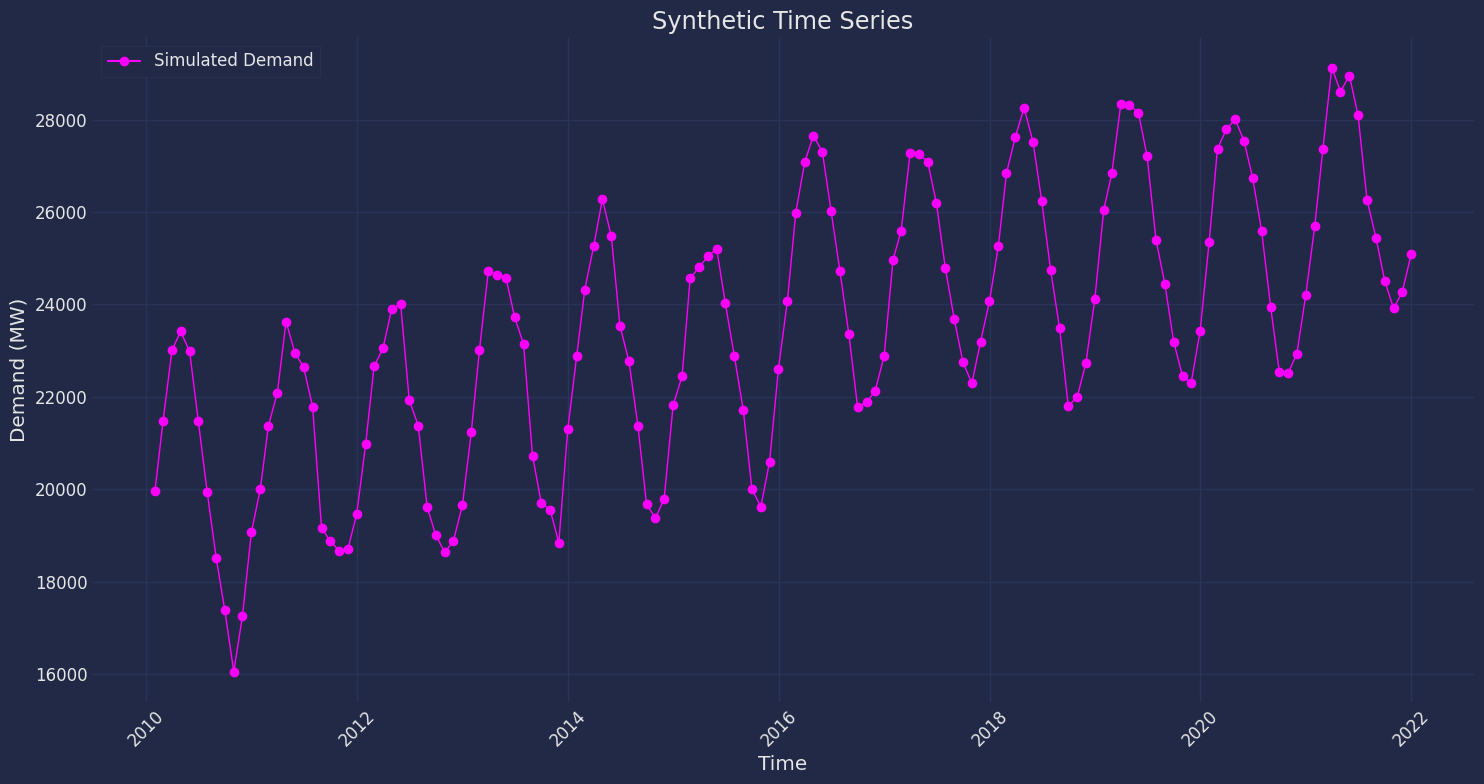

In [14]:
# Plot the data
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['values'], label='Simulated Demand', color='fuchsia', marker='o')
plt.title('Synthetic Time Series')
plt.xlabel('Time')
plt.ylabel('Demand (MW)')
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(1.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Data Preparation

In [15]:
def train_test_split(df: pd.DataFrame, test_size: Union[float, int]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and testing sets.

    Parameters:
        df: pd.DataFrame with a datetime index and a 'values' column.
        test_size: Either a float between 0 and 1 representing the percentage of data to use as the test set,
                   or a positive integer representing the number of time steps to reserve for testing.

    Returns:
        train_df: DataFrame for model fitting/training.
        test_df: DataFrame for evaluation/forecasting.
    """
    n = len(df)

    if isinstance(test_size, float):
        if test_size <= 0 or test_size >= 1:
            raise ValueError("If provided as a float, test_size must be between 0 and 1.")
        forecast_horizon = int(np.ceil(n * test_size))
    elif isinstance(test_size, int):
        if test_size <= 0 or test_size >= n:
            raise ValueError("If provided as an integer, test_size must be positive and less than the total number of observations.")
        forecast_horizon = test_size
    else:
        raise TypeError("test_size must be either a float (for a percentage) or an integer (for a fixed number of time steps).")

    train_df = df.iloc[:-forecast_horizon]
    test_df = df.iloc[-forecast_horizon:]
    return train_df, test_df

In [16]:
# Validate the splitting function
forecast_horizon = 12
train_df, test_df = train_test_split(df, test_size=forecast_horizon)
print(f"Training Data Shape: {train_df.shape}")
print(f"Testing Data Shape: {test_df.shape}")

Training Data Shape: (132, 1)
Testing Data Shape: (12, 1)


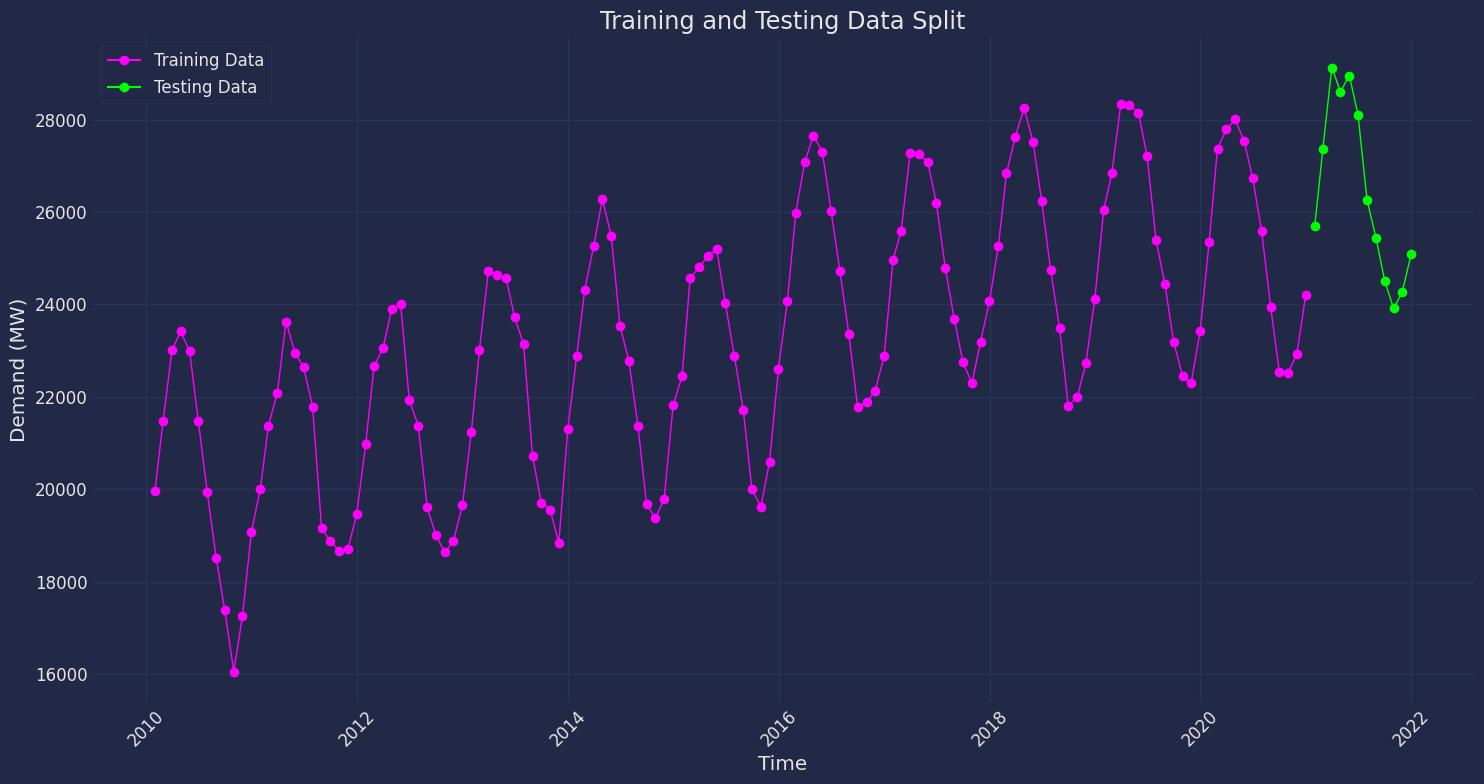

In [17]:
# Visualize the split
plt.figure(figsize=(15, 8))
plt.plot(train_df.index, train_df['values'], label='Training Data', color='fuchsia', marker='o')
plt.plot(test_df.index, test_df['values'], label='Testing Data', color='lime', marker='o')
plt.title('Training and Testing Data Split')
plt.xlabel('Time')
plt.ylabel('Demand (MW)')
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(1.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Model Forecasting

## Frequentist ARIMA Model

In [18]:
def monkey_patch_deprecated_param(func, deprecated_param, new_param):
    """
    Monkey-patch a function to map a deprecated parameter name to a new one.

    Parameters:
        func (callable): The original function to patch.
        deprecated_param (str): The old parameter name.
        new_param (str): The new parameter name to map to.

    Returns:
        callable: The patched function.
    """
    # Check if the function is already patched by verifying if _original exists
    if hasattr(func, '_original'):
        return func

    # Save a reference to the original function
    original_func = func

    def patched_func(*args, **kwargs):
        # If the deprecated parameter is provided, remap it
        if deprecated_param in kwargs:
            kwargs[new_param] = kwargs.pop(deprecated_param)
        return patched_func._original(*args, **kwargs)

    # Store the original function and mark as patched
    patched_func._original = original_func
    patched_func._monkey_patched = True

    return patched_func

In [19]:
# Monkey-patch the deprecated parameter
from sklearn.utils import validation
validation.check_array = monkey_patch_deprecated_param(
    validation.check_array,
    'force_all_finite',
    'ensure_all_finite'
)

In [20]:
def frequentist_arima(
    df: pd.DataFrame,
    forecast_horizon: int = 12,
    interval_method: str = "delta",
    n_simulations: int = 10000,
    clip_bounds: str = "default"
) -> np.ndarray:
    """
    Frequentist ARIMA Model using pmdarima.

    Parameters:
        df: DataFrame containing the time series with a 'values' column.
        forecast_horizon: The number of periods to forecast.
        interval_method: Which method to use for computing prediction intervals on the original scale.
                         Options are "delta" and "simulation".
        n_simulations: Number of simulations to run if simulation method is chosen.
        clip_bounds: Whether to clip the interval bounds. Options: 'default', 'both', 'lower', or 'upper'.

    Returns:
        forecast_mean: The point forecasts as a NumPy array.
        arima_save_path: Path to the saved plot.
    """
    import warnings
    warnings.filterwarnings('ignore', category=FutureWarning)

    # Log-transform the data
    df_copy = df.copy()
    df_copy['values'] = np.log(df_copy['values'])

    # Split the data into training and test sets
    train_df, test_df = train_test_split(df_copy, forecast_horizon)
    train = train_df['values'].values

    # Fit the (S)ARIMA model using auto_arima
    arima = pmd.auto_arima(
        train,
        start_p=1,
        start_q=1,
        max_p=2,
        max_q=2,
        start_P=0,
        start_Q=0,
        max_P=1,
        max_Q=1,
        m=12,  # seasonal period: annual seasonality for monthly data
        seasonal=True,
        d=None,
        D=1,
        test='adf',
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=False,
        random=True,
        n_fits=10,
        random_state=42
    )

    # Generate forecasts along with confidence intervals on the log scale
    forecast_mean_log, conf_int_log = arima.predict(n_periods=forecast_horizon, return_conf_int=True)

    # Estimate the forecast error standard deviation on the log scale
    # For a 95% CI, z is approximately 1.96
    from scipy.stats import norm
    z = norm.ppf(0.975)
    sigma_estimate = (conf_int_log[:, 1] - conf_int_log[:, 0]) / (2 * z)

    # Compute forecasts on the original scale based on the selected interval method
    if interval_method == "delta":
        # Delta method: The forecast mean on the original scale is approximated as:
        # E[Y] = exp(mu + sigma^2/2)
        forecast_mean = np.exp(forecast_mean_log + (sigma_estimate**2) / 2)
        # Delta method standard error on the original scale is approximated as:
        # SE ≈ exp(mu + sigma^2/2) * sigma
        delta_std = forecast_mean * sigma_estimate
        lower_bound = forecast_mean - z * delta_std
        upper_bound = forecast_mean + z * delta_std

    elif interval_method == "simulation":
        # Simulation method: Simulate n_simulations samples from the log-scale forecast distribution,
        # then transform back to the original scale
        sim_samples = np.random.normal(
            loc=forecast_mean_log,
            scale=sigma_estimate,
            size=(n_simulations, forecast_horizon)
        )
        sim_samples_exp = np.exp(sim_samples)
        forecast_mean = np.mean(sim_samples_exp, axis=0)
        lower_bound = np.percentile(sim_samples_exp, 2.5, axis=0)
        upper_bound = np.percentile(sim_samples_exp, 97.5, axis=0)

    else:
        raise ValueError("Invalid interval_method. Use 'delta' or 'simulation'.")

    # Optionally clip the bounds using a reasonable distance from the forecast mean
    if clip_bounds == "default":
        pass  # no clipping
    elif clip_bounds == "both":
        lower_limit = forecast_mean * 0.01
        upper_limit = forecast_mean * 2.0
        lower_bound = np.maximum(lower_bound, lower_limit)
        upper_bound = np.minimum(upper_bound, upper_limit)
        print("Both interval bounds have been clipped based on forecast mean.")
    elif clip_bounds == "lower":
        lower_limit = forecast_mean * 0.01
        lower_bound = np.maximum(lower_bound, lower_limit)
        print("The lower interval bound has been clipped based on forecast mean.")
    elif clip_bounds == "upper":
        upper_limit = forecast_mean * 2.0
        upper_bound = np.minimum(upper_bound, upper_limit)
        print("The upper interval bound has been clipped based on forecast mean.")
    else:
        raise ValueError("Invalid clip_bounds value. Use 'default', 'both', 'lower', or 'upper'.")

    # Use the test set's index for plotting the forecast period
    forecast_index = test_df.index

    # Plot the forecast
    print("\n")
    arima_save_path = plot_forecast(
        df,
        forecast_index,
        forecast_mean,
        lower_bound,
        upper_bound,
        model_name="Frequentist ARIMA"
    )

    # Clean up memory
    import gc
    del arima
    gc.collect()

    return forecast_mean, arima_save_path

In [21]:
# Obtain the forecast
arima_forecast, arima_save_path = frequentist_arima(
    df,
    forecast_horizon=forecast_horizon,
    interval_method='simulation',
    n_simulations=10000,
    clip_bounds='both'
)

In [22]:
# Download the plot
files.download(arima_save_path)

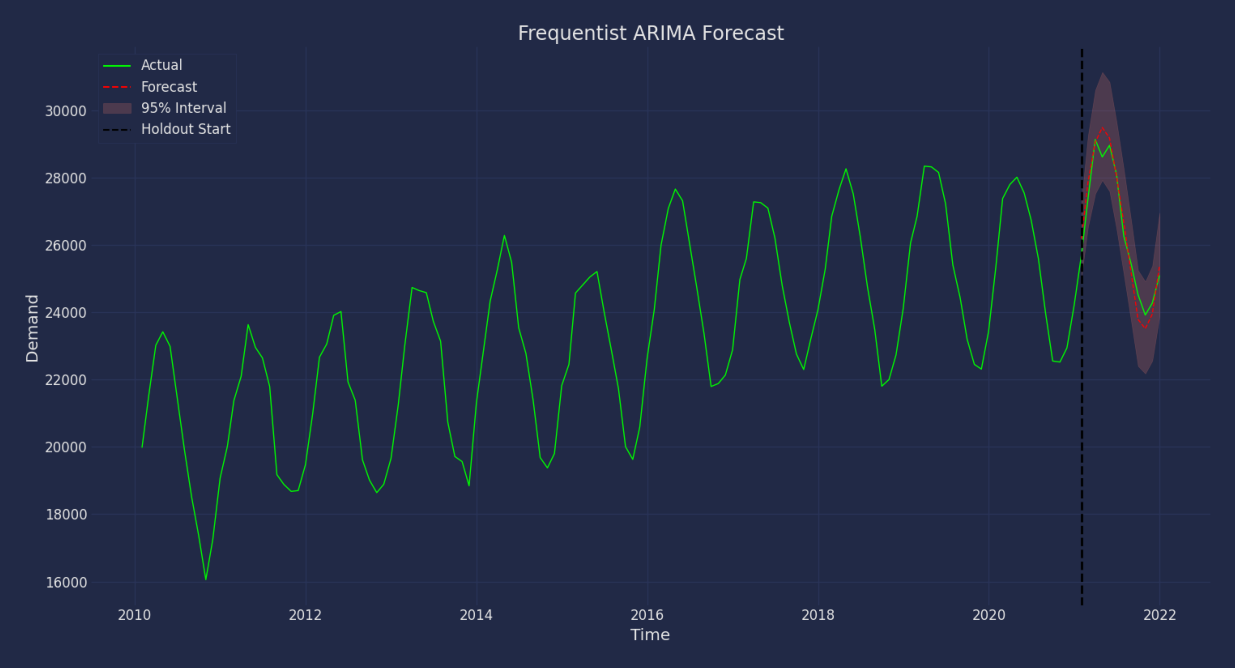

In [23]:
# Load the saved plot
arima_save_path = '/content/forecast_plot_9efe2529018348319507482bbb4011df.png'
arima_img = mpimg.imread(arima_save_path)
plt.figure(figsize=(15, 8))
plt.imshow(arima_img)
plt.axis('off')
plt.show()

In [24]:
# Save the forecast
joblib.dump(arima_forecast, 'arima_forecast.joblib')

# Download the file
files.download('arima_forecast.joblib')

## Bayesian Dynamic Linear Model

In [25]:
def bayesian_dlm(df: pd.DataFrame, forecast_horizon: int = 12) -> np.ndarray:
    """
    Bayesian Dynamic Linear Model (DLM) using PyMC.

    This model includes:
      - A trend component modeled as a Gaussian random walk.
      - An AR(1) error component.
      - An annual seasonal component for monthly data.

    Forecasts are generated by simulating the predictive distribution using posterior samples.

    Parameters:
        df: pd.DataFrame with a datetime index and a 'values' column.
        forecast_horizon: Number of periods to forecast.

    Returns:
        forecast_mean: The point forecasts as a NumPy array.
        bdlm_save_path: Path to the saved plot.
    """
    import warnings
    warnings.filterwarnings('ignore', category=UserWarning)
    warnings.filterwarnings('ignore', category=RuntimeWarning)

    # Log-transform the data
    df_copy = df.copy()
    df_copy['values'] = np.log(df_copy['values'])

    # Split the data into training and test sets
    train_df, test_df = train_test_split(df_copy, forecast_horizon)

    with pm.Model() as model:
        # Priors for noise and trend volatility
        sigma = pm.HalfNormal('sigma', sigma=1)
        trend_sigma = pm.HalfNormal('trend_sigma', sigma=0.1)
        ar_coef = pm.Normal('ar_coef', mu=0, sigma=0.5)

        # Trend component: Gaussian random walk
        trend = pm.GaussianRandomWalk('trend', sigma=trend_sigma, shape=len(train_df))

        # AR(1) component for residual errors using the AR API
        init_dist = pm.Normal.dist(0, 100, size=1)
        ar = pm.AR(
            'ar',
            rho=[ar_coef],
            sigma=sigma,
            init_dist=init_dist,
            steps=len(train_df),
            constant=False,
            ar_order=1
        )

        # Seasonal component: Annual seasonality for monthly data
        seasonal_period = 12
        seasonal = pm.Normal('seasonal', mu=0, sigma=0.5, shape=seasonal_period)

        # Seasonal indices for training data
        idx_seasonal = np.arange(len(train_df)) % seasonal_period

        # Combined expected value from trend, AR, and seasonal component
        mu = trend + ar[1:] + seasonal[idx_seasonal]

        # Likelihood for the observed data
        y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=train_df['values'])

        # Sample from the posterior
        trace = pm.sample(
            draws=2000,
            tune=1000,
            return_inferencedata=False,
            progressbar=True,
            target_accept=0.95
        )

    # Print the shapes of the trace arrays
    print("\n")
    print("trend shape:", trace['trend'].shape)
    print("ar shape:", trace['ar'].shape)
    print("trend_sigma shape:", trace['trend_sigma'].shape)
    print("ar_coef shape:", trace['ar_coef'].shape)
    print("seasonal shape:", trace['seasonal'].shape)

    # --- Forecasting via Posterior Predictive Simulation ---
    n_samples = trace['trend'].shape[0]
    forecast_samples = np.zeros((n_samples, forecast_horizon))

    # Forecast seasonal indices for the forecast horizon
    forecast_indices = np.arange(len(train_df), len(train_df) + forecast_horizon)
    idx_seasonal_forecast = forecast_indices % seasonal_period

    for i in range(n_samples):
        # Simulate trend forecast: continue the random walk simulation
        trend_forecast = np.zeros(forecast_horizon)
        trend_forecast[0] = trace['trend'][i, -1] + np.random.normal(0, trace['trend_sigma'][i])
        for t in range(1, forecast_horizon):
            trend_forecast[t] = trend_forecast[t-1] + np.random.normal(0, trace['trend_sigma'][i])

        # Simulate AR(1) forecast recursively
        phi = trace['ar_coef'][i]
        ar_last = trace['ar'][i, -1]
        forecast_ar = np.zeros(forecast_horizon)
        for t in range(forecast_horizon):
            if t == 0:
                forecast_ar[t] = phi * ar_last + np.random.normal(0, trace['sigma'][i])
            else:
                forecast_ar[t] = phi * forecast_ar[t-1] + np.random.normal(0, trace['sigma'][i])

        # Seasonal effects for forecast horizon
        seasonal_effect = trace['seasonal'][i][idx_seasonal_forecast]

        # Combine simulated trend, AR forecast, and seasonal effects
        forecast_samples[i, :] = trend_forecast + forecast_ar + seasonal_effect

    # Invert the log transformation
    forecast_samples = np.exp(forecast_samples)

    # Compute the mean and intervals
    forecast_mean = np.mean(forecast_samples, axis=0)
    lower_bound = np.percentile(forecast_samples, 2.5, axis=0)
    upper_bound = np.percentile(forecast_samples, 97.5, axis=0)

    # Use the test set's index for plotting the forecast period
    forecast_index = test_df.index

    # Plot the forecast
    print("\n")
    bdlm_save_path = plot_forecast(
        df,
        forecast_index,
        forecast_mean,
        lower_bound,
        upper_bound,
        model_name="Bayesian DLM"
    )

    # Clean up memory
    import gc
    del model, trace
    gc.collect()

    return forecast_mean, bdlm_save_path

In [26]:
# Obtain the forecast
bdlm_forecast, bdlm_save_path = bayesian_dlm(
    df,
    forecast_horizon=forecast_horizon
)

In [27]:
# Download the plot
files.download(bdlm_save_path)

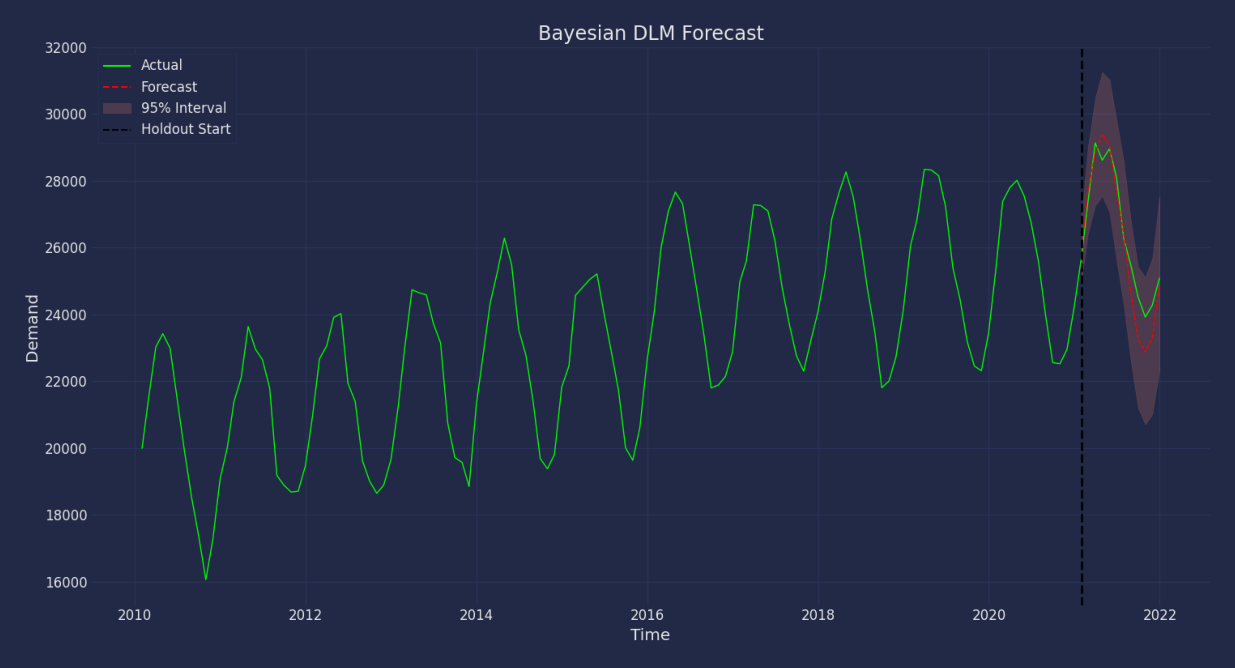

In [28]:
# Load the saved plot
bdlm_save_path = '/content/forecast_plot_bad8ca150f1243c495c77bb7af772bdf.png'
bdlm_img = mpimg.imread(bdlm_save_path)
plt.figure(figsize=(15, 8))
plt.imshow(bdlm_img)
plt.axis('off')
plt.show()

In [29]:
# Save the forecast
joblib.dump(bdlm_forecast, 'bdlm_forecast.joblib')

# Download the file
files.download('bdlm_forecast.joblib')

In [30]:
@numba.njit
def simulate_ar(phi, sigma, ar_last, forecast_horizon):
    """
    Simulate AR(1) process using Numba for JIT compilation.
    """
    forecast_ar = np.empty(forecast_horizon)
    forecast_ar[0] = phi * ar_last + np.random.normal(0, sigma)
    for t in range(1, forecast_horizon):
        forecast_ar[t] = phi * forecast_ar[t-1] + np.random.normal(0, sigma)
    return forecast_ar

In [31]:
def bayesian_dlm2(df: pd.DataFrame, forecast_horizon: int = 12) -> np.ndarray:
    """
    Bayesian Dynamic Linear Model (DLM) using PyMC.

    This model includes:
      - A trend component modeled as a Gaussian random walk.
      - An AR(1) error component.
      - An annual seasonal component for monthly data.

    Forecasts are generated by simulating the predictive distribution using posterior samples.

    Parameters:
        df: pd.DataFrame with a datetime index and a 'values' column.
        forecast_horizon: Number of periods to forecast.

    Returns:
        forecast_mean: The point forecasts as a NumPy array.
        bdlm_save_path: Path to the saved plot.
    """
    import warnings
    warnings.filterwarnings('ignore', category=UserWarning)
    warnings.filterwarnings('ignore', category=RuntimeWarning)

    # Log-transform the data
    df_copy = df.copy()
    df_copy['values'] = np.log(df_copy['values'])

    # Split the data into training and test sets
    train_df, test_df = train_test_split(df_copy, forecast_horizon)

    with pm.Model() as model:
        # Priors for noise and trend volatility
        sigma = pm.HalfNormal('sigma', sigma=1)
        trend_sigma = pm.HalfNormal('trend_sigma', sigma=0.1)
        ar_coef = pm.Normal('ar_coef', mu=0, sigma=0.5)

        # Trend component: Gaussian random walk
        trend = pm.GaussianRandomWalk('trend', sigma=trend_sigma, shape=len(train_df))

        # AR(1) component for residual errors using the AR API
        init_dist = pm.Normal.dist(0, 100, size=1)
        ar = pm.AR(
            'ar',
            rho=[ar_coef],
            sigma=sigma,
            init_dist=init_dist,
            steps=len(train_df),
            constant=False,
            ar_order=1
        )

        # Seasonal component: Annual seasonality for monthly data (period=12)
        seasonal_period = 12
        seasonal = pm.Normal('seasonal', mu=0, sigma=0.5, shape=seasonal_period)

        # Seasonal indices for training data
        idx_seasonal = np.arange(len(train_df)) % seasonal_period

        # Combined expected value from trend, AR, and seasonal components
        mu = trend + ar[1:] + seasonal[idx_seasonal]

        # Likelihood for the observed data
        y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=train_df['values'])

        # Sample from the posterior
        trace = pm.sample(
            draws=2000,
            tune=1000,
            return_inferencedata=False,
            progressbar=True,
            target_accept=0.95
        )

    # Print the shapes of the trace arrays
    print("\n")
    print("trend shape:", trace['trend'].shape)
    print("ar shape:", trace['ar'].shape)
    print("trend_sigma shape:", trace['trend_sigma'].shape)
    print("ar_coef shape:", trace['ar_coef'].shape)
    print("seasonal shape:", trace['seasonal'].shape)

    # --- Forecasting via Posterior Predictive Simulation ---
    n_samples = trace['trend'].shape[0]
    forecast_samples = np.zeros((n_samples, forecast_horizon))

    # Forecast seasonal indices for the forecast horizon
    forecast_indices = np.arange(len(train_df), len(train_df) + forecast_horizon)
    idx_seasonal_forecast = forecast_indices % seasonal_period

    # Loop over each posterior sample with progress monitoring
    for i in tqdm(range(n_samples), desc="Forecasting samples"):
        # Vectorized simulation for the trend forecast using cumulative sum
        increments = np.random.normal(0, trace['trend_sigma'][i], size=forecast_horizon)
        trend_forecast = trace['trend'][i, -1] + np.cumsum(increments)

        # Optimized AR(1) forecast simulation using the numba-compiled function
        phi = trace['ar_coef'][i]
        ar_last = trace['ar'][i, -1]
        forecast_ar = simulate_ar(phi, trace['sigma'][i], ar_last, forecast_horizon)

        # Seasonal effects for forecast horizon from the sampled seasonal component
        seasonal_effect = trace['seasonal'][i][idx_seasonal_forecast]

        # Combine simulated components for forecast sample
        forecast_samples[i, :] = trend_forecast + forecast_ar + seasonal_effect

    # Invert the log transformation
    forecast_samples = np.exp(forecast_samples)

    # Compute the mean and intervals
    forecast_mean = np.mean(forecast_samples, axis=0)
    lower_bound = np.percentile(forecast_samples, 2.5, axis=0)
    upper_bound = np.percentile(forecast_samples, 97.5, axis=0)

    # Use the test set's index for plotting the forecast period
    forecast_index = test_df.index

    # Plot the forecast
    print("\n")
    bdlm_save_path = plot_forecast(
        df,
        forecast_index,
        forecast_mean,
        lower_bound,
        upper_bound,
        model_name="Bayesian DLM2"
    )

    # Clean up memory
    import gc
    del model, trace
    gc.collect()

    return forecast_mean, bdlm_save_path

In [32]:
# Obtain the forecast
bdlm2_forecast, bdlm2_save_path = bayesian_dlm2(
    df,
    forecast_horizon=forecast_horizon
)

In [33]:
# Download the plot
files.download(bdlm2_save_path)

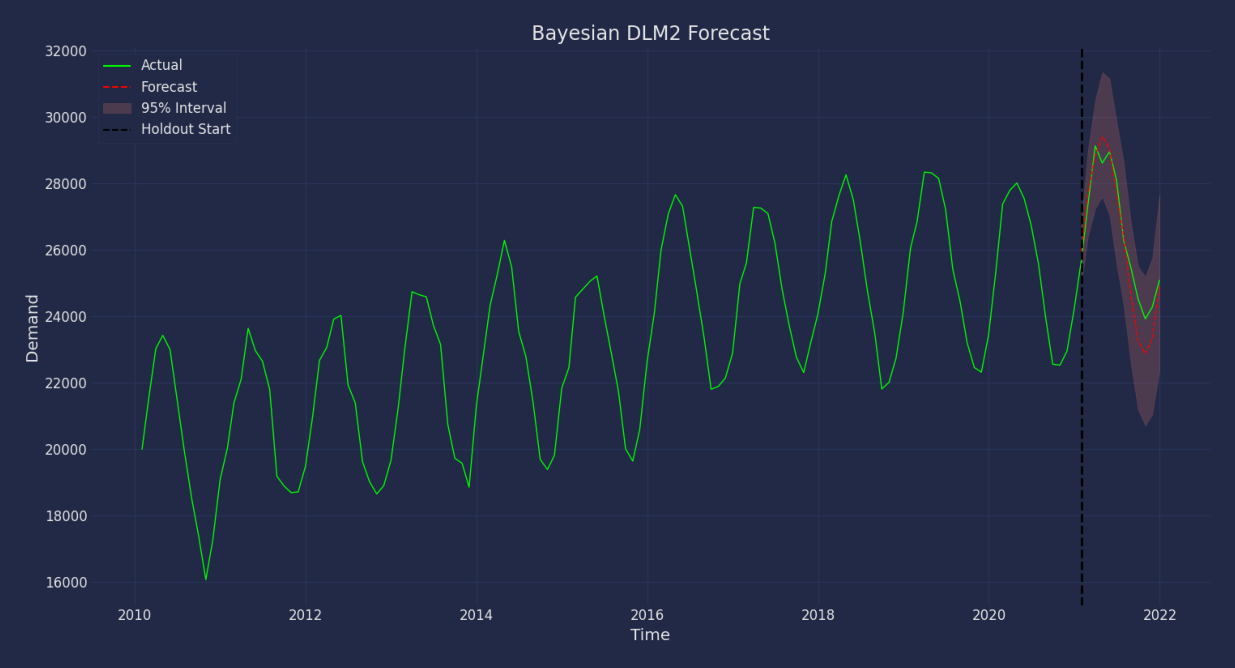

In [34]:
# Load the saved plot
bdlm2_save_path = '/content/forecast_plot_a519b1041a6042698b14bfd1222cc478.png'
bdlm2_img = mpimg.imread(bdlm2_save_path)
plt.figure(figsize=(15, 8))
plt.imshow(bdlm2_img)
plt.axis('off')
plt.show()

In [35]:
# Save the forecast
joblib.dump(bdlm2_forecast, 'bdlm2_forecast.joblib')

# Download the file
files.download('bdlm2_forecast.joblib')

## Bayesian Unobserved Components Model

In [36]:
def bayesian_ucm(df: pd.DataFrame, forecast_horizon: int = 12) -> np.ndarray:
    """
    Bayesian Unobserved Components Model using pybuc.

    This implementation includes:
      - A local trend component (with level and slope).
      - An annual seasonal component modeled via trigonometric terms.

    Parameters:
        df: pd.DataFrame with a datetime index and a 'values' column.
        forecast_horizon: Number of periods to forecast.

    Returns:
        forecast_mean: The point forecasts as a NumPy array.
        bucm_save_path: Path to the saved plot.
    """
    # Log-transform the data
    df_copy = df.copy()
    df_copy['values'] = np.log(df_copy['values'])

    # Split the data into training and test sets
    train_df, test_df = train_test_split(df_copy, forecast_horizon)
    y_train = train_df['values']

    # Define and fit the Bayesian Unobserved Components model using pybuc
    bayes_uc = BayesianUnobservedComponents(
        response=y_train,
        level=True,
        stochastic_level=True,
        trend=True,
        stochastic_trend=True,
        trig_seasonal=((12, 0),),  # annual seasonality for monthly data
        stochastic_trig_seasonal=(True,),
        seed=123
    )

    # Draw posterior samples
    print("Sampling...")
    post = bayes_uc.sample(2000)
    burn = 1000

    # Generate forecasts for the specified horizon
    print("\nForecasting...")
    forecast, _ = bayes_uc.forecast(num_periods=forecast_horizon, burn=burn)

    # Invert the log transformation
    print("\nInverting log transformation...")
    forecast = np.exp(forecast)

    # Compute the mean and intervals
    forecast_mean = np.mean(forecast, axis=0)
    lower_bound = np.quantile(forecast, 0.025, axis=0).flatten()
    upper_bound = np.quantile(forecast, 0.975, axis=0).flatten()

    # Use the test set's index for plotting the forecast period
    forecast_index = test_df.index

    # Plot the forecast
    print("\nPlotting...\n")
    bucm_save_path = plot_forecast(
        df,
        forecast_index,
        forecast_mean,
        lower_bound,
        upper_bound,
        model_name="Bayesian UCM"
    )

    # Clean up memory
    import gc
    del bayes_uc, post, forecast
    gc.collect()

    return forecast_mean, bucm_save_path

In [37]:
# Obtain the forecast
bucm_forecast, bucm_save_path = bayesian_ucm(
    df,
    forecast_horizon=forecast_horizon
)

In [38]:
# Download the plot
files.download(bucm_save_path)

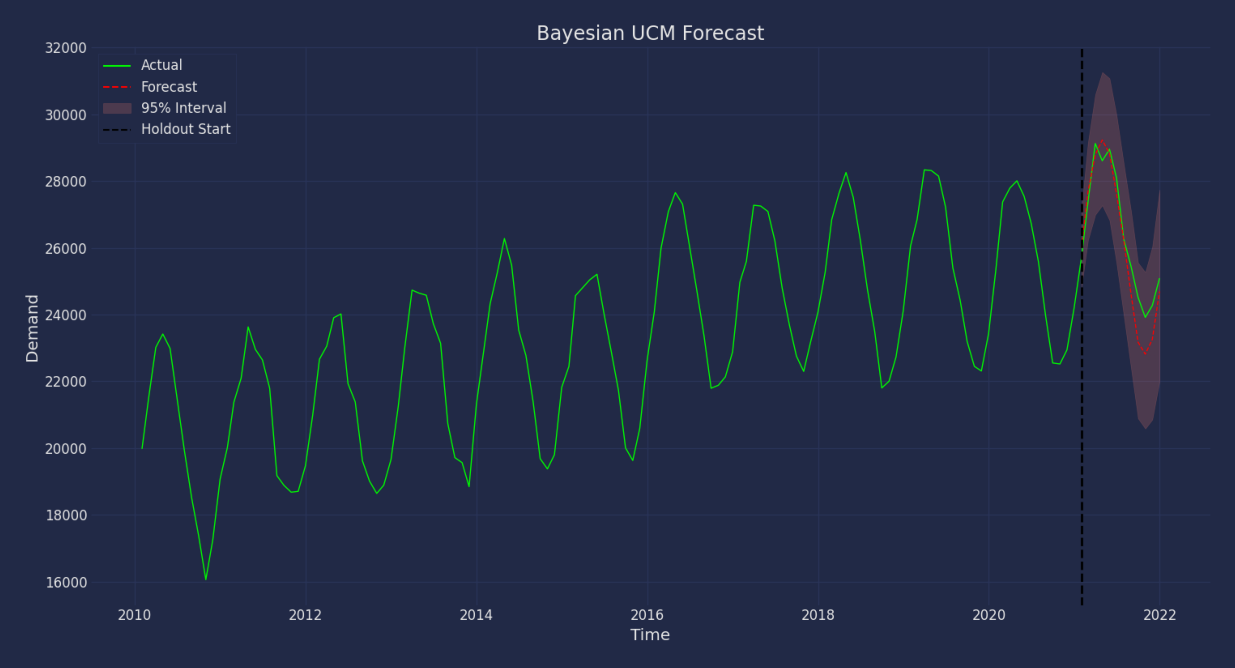

In [39]:
# Load the saved plot
bucm_save_path = '/content/forecast_plot_09ae05b0db414b14991dfa3b5ff6cf39.png'
bucm_image = mpimg.imread(bucm_save_path)
plt.figure(figsize=(15, 8))
plt.imshow(bucm_image)
plt.axis('off')
plt.show()

In [40]:
# Save the forecast
joblib.dump(bucm_forecast, 'bucm_forecast.joblib')

# Download the file
files.download('bucm_forecast.joblib')

## Bayesian Structural Time Series Model

In [41]:
def bayesian_stsm(df: pd.DataFrame, forecast_horizon: int = 12) -> np.ndarray:
    """
    Bayesian Structural Time Series (BSTS) model using bsts.

    Parameters:
        df: pd.DataFrame with a datetime index and a 'values' column.
        forecast_horizon: Number of periods to forecast.

    Returns:
        forecast_mean: The point forecasts as a NumPy array.
        bstsm_save_path: Path to the saved plot.
    """
    # Log-transform the data
    df_copy = df.copy()
    df_copy['values'] = np.log(df_copy['values'])

    # Split the data into training and test sets
    train_df, test_df = train_test_split(df_copy, forecast_horizon)
    y_train = train_df['values'].values

    # For monthly data, use an annual seasonality of 12 periods
    bsts_model = BSTS(seasonality=12)

    # Fit the BSTS model on the training data
    print("Sampling...")
    bsts_model.fit(
        y_train,
        num_warmup=100,
        num_samples=1000,
        num_chains=1
    )

    # Forecast for the specified horizon. The predict() method returns samples with shape
    # (num_samples, future), so we convert to a NumPy array
    print("\nForecasting...")
    forecast_samples = np.array(bsts_model.predict(future=forecast_horizon))

    # Invert the log transformation
    print("\nInverting log transformation...")
    forecast_samples = np.exp(forecast_samples)

    # Compute the mean and intervals
    forecast_mean = forecast_samples.mean(axis=0)
    lower_bound = np.quantile(forecast_samples, 0.025, axis=0)
    upper_bound = np.quantile(forecast_samples, 0.975, axis=0)

    # Use the test set's index for plotting the forecast period
    forecast_index = test_df.index

    # Plot the forecast
    print("\nPlotting...\n")
    bstsm_save_path = plot_forecast(
        df,
        forecast_index,
        forecast_mean,
        lower_bound,
        upper_bound,
        model_name="Bayesian STSM"
    )

    # Clean up memory
    import gc
    del bsts_model, forecast_samples
    gc.collect()

    return forecast_mean, bstsm_save_path

In [42]:
# Obtain the forecast
bstsm_forecast, bstsm_save_path = bayesian_stsm(
    df,
    forecast_horizon=forecast_horizon
)

In [43]:
# Download the plot
files.download(bstsm_save_path)

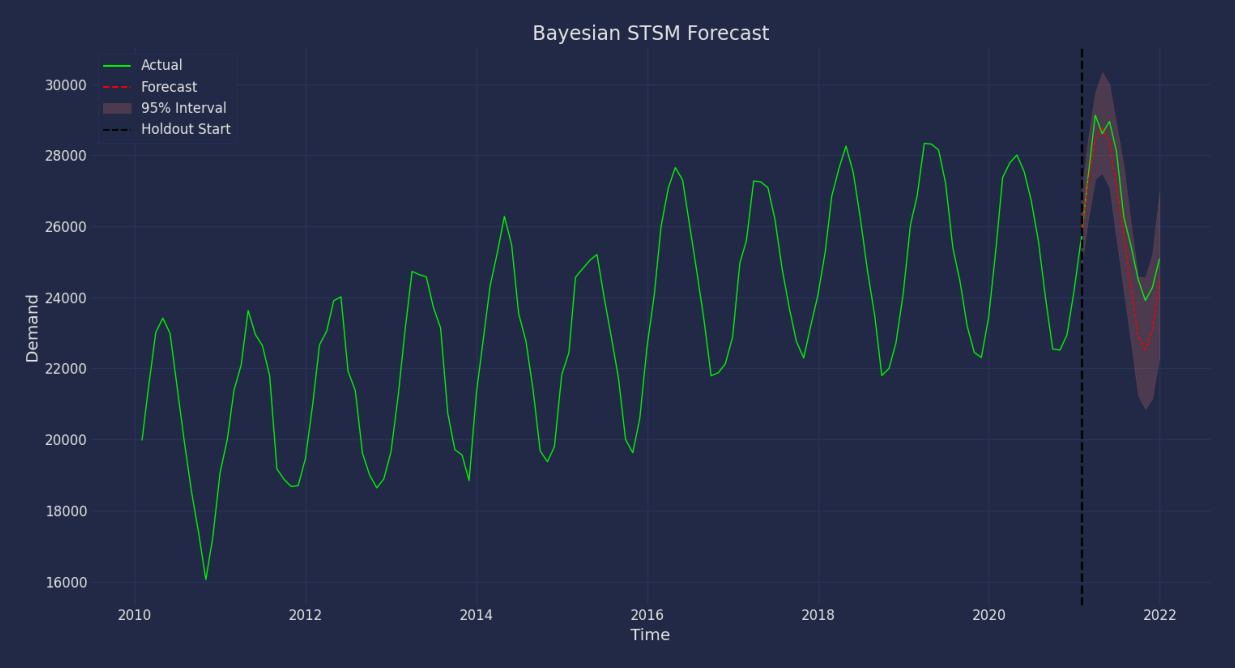

In [44]:
# Load the saved plot
bstsm_save_path = '/content/forecast_plot_3e1e816cdfa547b98aa4400ca27fd75a.png'
bstsm_image = mpimg.imread(bstsm_save_path)
plt.figure(figsize=(15, 8))
plt.imshow(bstsm_image)
plt.axis('off')
plt.show()

In [45]:
# Save the forecast
joblib.dump(bstsm_forecast, 'bstsm_forecast.joblib')

# Download the file
files.download('bstsm_forecast.joblib')

## Bayesian Neural Network Model

In [46]:
# Clear memory
torch.cuda.empty_cache()

# Clear the parameter store
pyro.clear_param_store()

In [47]:
def bayesian_nnm(
    df: 'pd.DataFrame',
    forecast_horizon: int = 12,
    lookback: int = 12,
    lstm_hidden_dim: int = 32,
    num_lstm_layers: int = 1,
    mlp_hidden_dim: int = 32,
    learning_rate: float = 0.001,
    num_epochs: int = 1000,
    num_predictive_samples: int = 1000,
    seed: int = 42,
    use_lstm: bool = True,
    scaling_method: str = "minmax",
    device: Optional[torch.device] = None,
    print_every: int = 100,
    clip_bounds: str = "default"
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Bayesian Neural Network Model using Pyro and PyTorch.

    Parameters:
        df: pd.DataFrame with a datetime index and a 'values' column.
        forecast_horizon: Number of periods to forecast.
        lookback: Number of past time steps used as input features.
        lstm_hidden_dim: Number of hidden units in the LSTM layer.
        num_lstm_layers: Number of LSTM layers to use if use_lstm is True.
        mlp_hidden_dim: Number of hidden units in the Bayesian MLP layers.
        learning_rate: Learning rate for the optimizer.
        num_epochs: Number of training epochs.
        num_predictive_samples: Number of samples for the predictive distribution.
        seed: Random seed for reproducibility.
        use_lstm: Flag to indicate if an LSTM layer should be used (default True).
        scaling_method: "minmax" for min–max scaling (default) or "standard" for standardization, both based on training statistics.
        device: PyTorch device to use.
        print_every: Frequency (in epochs) to print training loss.
        clip_bounds: Whether to clip the interval bounds. Options: 'default', 'both', 'lower', or 'upper'.

    Returns:
        forecast_mean: The point forecasts as a NumPy array.
        bnnm_save_path: Path to the saved forecast plot.
    """
    # Ensure device is set
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Clear Pyro's parameter store
    pyro.clear_param_store()

    # Set random seeds for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    pyro.set_rng_seed(seed)
    random.seed(seed)

    # Split the data into training and test sets
    train_df, test_df = train_test_split(df, forecast_horizon)
    train_df = train_df.copy()
    test_df = test_df.copy()

    # Compute training statistics and scale the data
    if scaling_method == "minmax":
        train_min = train_df['values'].min()
        train_max = train_df['values'].max()
        train_df.loc[:, 'values'] = (train_df['values'] - train_min) / (train_max - train_min)
        test_df.loc[:, 'values'] = (test_df['values'] - train_min) / (train_max - train_min)
    elif scaling_method == "standard":
        train_mean = train_df['values'].mean()
        train_std = train_df['values'].std()
        train_df.loc[:, 'values'] = (train_df['values'] - train_mean) / train_std
        test_df.loc[:, 'values'] = (test_df['values'] - train_mean) / train_std
    else:
        raise ValueError("scaling_method must be either 'minmax' or 'standard'")

    # Create sliding-window sequences
    def prepare_data(data: 'pd.DataFrame', lookback: int):
        values = data['values'].values
        if len(values) <= lookback:
            raise ValueError("Not enough data to create sequences given the lookback window\n")
        X, y = [], []
        for i in range(len(values) - lookback):
            X.append(values[i:i+lookback])
            y.append(values[i+lookback])
        X = np.array(X)
        y = np.array(y)
        # Reshape X to (batch, lookback, input_size)
        X = X.reshape(-1, lookback, 1)
        return torch.FloatTensor(X).to(device), torch.FloatTensor(y).to(device)

    X_train, y_train = prepare_data(train_df, lookback)
    if len(test_df) <= lookback:
        test_df_full = pd.concat([train_df.iloc[-lookback:], test_df])
    else:
        test_df_full = test_df.copy()
    X_test, y_test = prepare_data(test_df_full, lookback)

    # Define the Bayesian Neural Network
    class TimeSeriesModel(PyroModule):
        def __init__(self, input_size: int = 1, lstm_hidden_dim: int = 32, mlp_hidden_dim: int = 32,
                     num_lstm_layers: int = 1, output_size: int = 1, use_lstm: bool = True):
            super().__init__()
            self.use_lstm = use_lstm  # Flag indicating whether to use the LSTM
            if self.use_lstm:
                # Deterministic LSTM layer to extract temporal features
                self.lstm = nn.LSTM(input_size, lstm_hidden_dim, num_lstm_layers, batch_first=True)
                mlp_input_dim = lstm_hidden_dim  # The MLP receives the LSTM's last hidden state
            else:
                # If no LSTM is used, flatten the input sequence and use its dimension as input to the MLP
                self.lstm = None
                mlp_input_dim = lookback * input_size

            # Bayesian MLP layers: two hidden layers and an output layer
            self.hidden1 = PyroModule[nn.Linear](mlp_input_dim, mlp_hidden_dim)
            self.hidden2 = PyroModule[nn.Linear](mlp_hidden_dim, mlp_hidden_dim)
            self.output = PyroModule[nn.Linear](mlp_hidden_dim, output_size)
            self.activation = nn.ReLU()

            # Wrap the MLP layer parameters as Bayesian using Normal(0,1) priors
            self.hidden1.weight = PyroSample(
                dist.Normal(torch.tensor(0., device=device), torch.tensor(1., device=device))
                .expand([mlp_hidden_dim, mlp_input_dim]).to_event(2)
            )
            self.hidden1.bias = PyroSample(
                dist.Normal(torch.tensor(0., device=device), torch.tensor(1., device=device))
                .expand([mlp_hidden_dim]).to_event(1)
            )
            self.hidden2.weight = PyroSample(
                dist.Normal(torch.tensor(0., device=device), torch.tensor(1., device=device))
                .expand([mlp_hidden_dim, mlp_hidden_dim]).to_event(2)
            )
            self.hidden2.bias = PyroSample(
                dist.Normal(torch.tensor(0., device=device), torch.tensor(1., device=device))
                .expand([mlp_hidden_dim]).to_event(1)
            )
            self.output.weight = PyroSample(
                dist.Normal(torch.tensor(0., device=device), torch.tensor(1., device=device))
                .expand([output_size, mlp_hidden_dim]).to_event(2)
            )
            self.output.bias = PyroSample(
                dist.Normal(torch.tensor(0., device=device), torch.tensor(1., device=device))
                .expand([output_size]).to_event(1)
            )

        def forward(self, x: torch.Tensor, y: torch.Tensor = None) -> torch.Tensor:
            # x has shape (batch, lookback, input_size)
            if self.use_lstm:
                lstm_out, _ = self.lstm(x)
                # Use the output from the last time step from the LSTM as features
                features = lstm_out[:, -1, :]
            else:
                # Flatten the input sequence for the MLP
                features = x.view(x.shape[0], -1)
            # Pass the features through the Bayesian MLP
            hidden = self.activation(self.hidden1(features))
            hidden = self.activation(self.hidden2(hidden))
            mu = self.output(hidden).squeeze(-1)
            # Sample observation noise
            sigma = pyro.sample("sigma",
                        dist.Gamma(torch.tensor(1.0, device=x.device),
                                   torch.tensor(1.0, device=x.device)))
            with pyro.plate("data", x.shape[0]):
                pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
            return mu

    # Instantiate the model and guide
    model = TimeSeriesModel(
        input_size=1,
        lstm_hidden_dim=lstm_hidden_dim,
        mlp_hidden_dim=mlp_hidden_dim,
        num_lstm_layers=num_lstm_layers,
        output_size=1,
        use_lstm=use_lstm
    ).to(device)
    guide = AutoLowRankMultivariateNormal(model).to(device)

    adam = Adam({"lr": learning_rate})
    svi = SVI(model, guide, adam, loss=RenyiELBO(alpha=0.5, num_particles=10))

    # Training loop
    for epoch in tqdm(range(num_epochs), desc="Training Bayesian Neural Network"):
        loss = svi.step(X_train, y_train)
        if (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch+1}, Loss: {loss}")

    # Print key Bayesian MLP parameters
    print("\nLearned hidden1.weight:\n", model.hidden1.weight.detach().cpu())
    print("Learned output.weight:\n", model.output.weight.detach().cpu())
    print("\n")

    # Prediction: one-step-ahead for each test sequence
    def predict_samples(model, guide, X_input, n_samples):
        predictive = Predictive(model, guide=guide, num_samples=n_samples)
        samples = predictive(X_input)
        return samples['obs']

    pred_samples = predict_samples(model, guide, X_test, num_predictive_samples)
    pred_samples_np = pred_samples.detach().cpu().numpy()  # shape: (n_samples, num_test_sequences)

    # Invert the scaling transformation for each predictive sample
    if scaling_method == "minmax":
        inv_transform = lambda x: x * (train_max - train_min) + train_min
    elif scaling_method == "standard":
        inv_transform = lambda x: x * train_std + train_mean

    pred_samples_inv = inv_transform(pred_samples_np)

    # Compute the mean and intervals from the inverse-transformed samples
    forecast_mean = pred_samples_inv.mean(axis=0)
    lower_bound = np.percentile(pred_samples_inv, 2.5, axis=0)
    upper_bound = np.percentile(pred_samples_inv, 97.5, axis=0)

    # Trim the forecast arrays if necessary
    # Will only contain predictions for the required forecast horizon
    if len(forecast_mean) > forecast_horizon:
        forecast_mean = forecast_mean[-forecast_horizon:]
        lower_bound = lower_bound[-forecast_horizon:]
        upper_bound = upper_bound[-forecast_horizon:]

    # Optionally clip the bounds using a reasonable distance from the forecast mean
    if clip_bounds == "default":
        pass  # no clipping
    elif clip_bounds == "both":
        lower_limit = forecast_mean * 0.01
        upper_limit = forecast_mean * 2.0
        lower_bound = np.maximum(lower_bound, lower_limit)
        upper_bound = np.minimum(upper_bound, upper_limit)
        print("Both interval bounds have been clipped based on forecast mean.")
    elif clip_bounds == "lower":
        lower_limit = forecast_mean * 0.01
        lower_bound = np.maximum(lower_bound, lower_limit)
        print("The lower interval bound has been clipped based on forecast mean.")
    elif clip_bounds == "upper":
        upper_limit = forecast_mean * 2.0
        upper_bound = np.minimum(upper_bound, upper_limit)
        print("The upper interval bound has been clipped based on forecast mean.")
    else:
        raise ValueError("Invalid clip_bounds value. Use 'default', 'both', 'lower', or 'upper'.")

    # Use the test set's index for plotting the forecast period
    forecast_index = test_df.index[-forecast_horizon:]

    # Plot the forecast
    print("\n")
    bnnm_save_path = plot_forecast(
        df,
        forecast_index,
        forecast_mean,
        lower_bound,
        upper_bound,
        model_name="Bayesian Neural Network"
    )

    # Clean up memory
    import gc
    del model, guide, adam, svi, pred_samples, pred_samples_np
    gc.collect()

    return forecast_mean, bnnm_save_path

In [48]:
# Obtain the forecast
lookback = 12 * 10  # 10 years
bnnm_forecast, bnnm_save_path = bayesian_nnm(
    df,
    forecast_horizon=forecast_horizon,
    lookback=lookback,
    lstm_hidden_dim=8,
    num_lstm_layers=1,
    mlp_hidden_dim=16,
    learning_rate=0.001,
    num_epochs=10000,
    num_predictive_samples=5000,
    use_lstm=True,
    clip_bounds='both',
    seed=42
)

In [49]:
# Download the plot
files.download(bnnm_save_path)

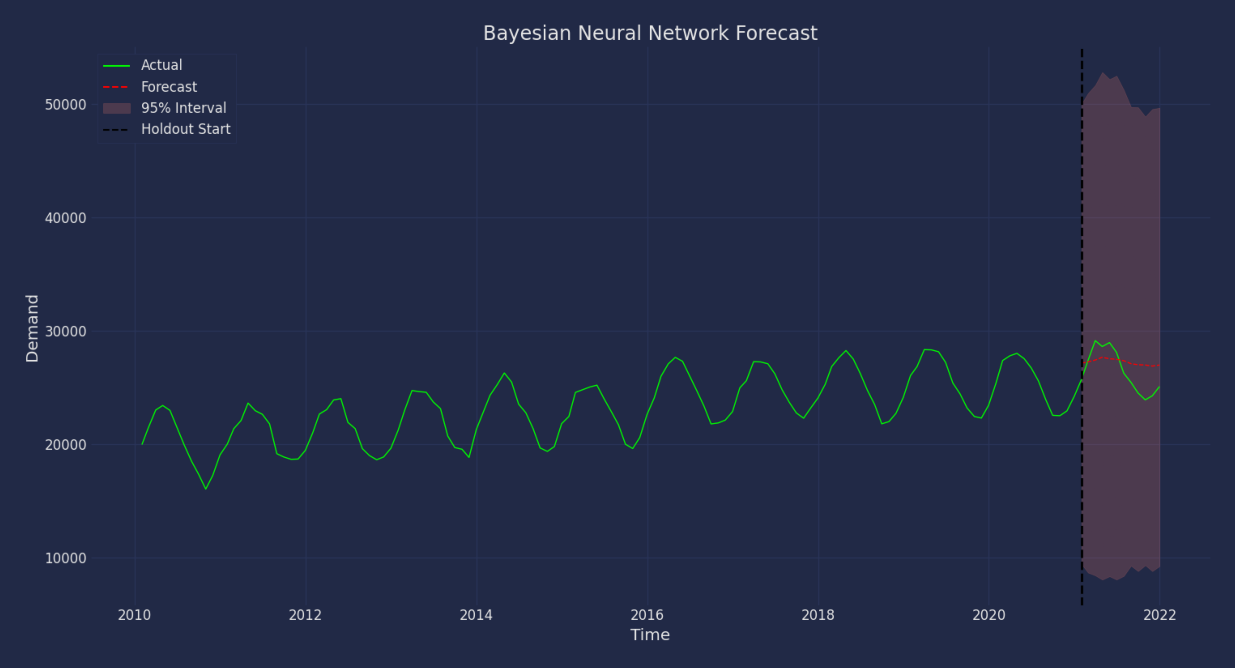

In [50]:
# Load the saved plot
bnnm_save_path = '/content/forecast_plot_a2947df9f9e440a28de1951849e6282b.png'
bnnm_image = mpimg.imread(bnnm_save_path)
plt.figure(figsize=(15, 8))
plt.imshow(bnnm_image)
plt.axis('off')
plt.show()

In [51]:
# Save the forecast
joblib.dump(bnnm_forecast, 'bnnm_forecast.joblib')

# Download the file
files.download('bnnm_forecast.joblib')

# Metrics Evaluation

In [52]:
# Extract the true values from the holdout period
y_true = df['values'].values[-forecast_horizon:]

In [53]:
# Load the forecasts
arima_forecast = joblib.load('arima_forecast.joblib')
bdlm_forecast = joblib.load('bdlm_forecast.joblib')
bdlm2_forecast = joblib.load('bdlm2_forecast.joblib')
bucm_forecast = joblib.load('bucm_forecast.joblib')
bstsm_forecast = joblib.load('bstsm_forecast.joblib')
bnnm_forecast = joblib.load('bnnm_forecast.joblib')

In [54]:
# Calculate error metrics
metrics: Dict[str, Tuple[float, float, float, float]] = {
    "Frequentist ARIMA": calculate_metrics(y_true, arima_forecast),
    "Bayesian DLM": calculate_metrics(y_true, bdlm_forecast),
    "Bayesian DLM2": calculate_metrics(y_true, bdlm2_forecast),
    "Bayesian UCM": calculate_metrics(y_true, bucm_forecast),
    "Bayesian STS": calculate_metrics(y_true, bstsm_forecast),
    "Bayesian NNM": calculate_metrics(y_true, bnnm_forecast)
}

df_metrics = pd.DataFrame(metrics, index=["RMSE", "MAE", "MAPE", "sMAPE"]).T
print("Forecasting Metrics:\n")
display(df_metrics)

Forecasting Metrics:



,RMSE,MAE,MAPE,sMAPE
Frequentist ARIMA,449.038033,385.257388,1.475539,1.473384
Bayesian DLM,671.645791,549.031846,2.144631,2.172667
Bayesian DLM2,670.044545,546.704564,2.134939,2.162607
Bayesian UCM,2923.342118,2400.670534,9.071801,9.178464
Bayesian STS,899.928413,753.164671,2.935137,3.000435
Bayesian NNM,1784.824281,1587.182915,6.184139,6.005261


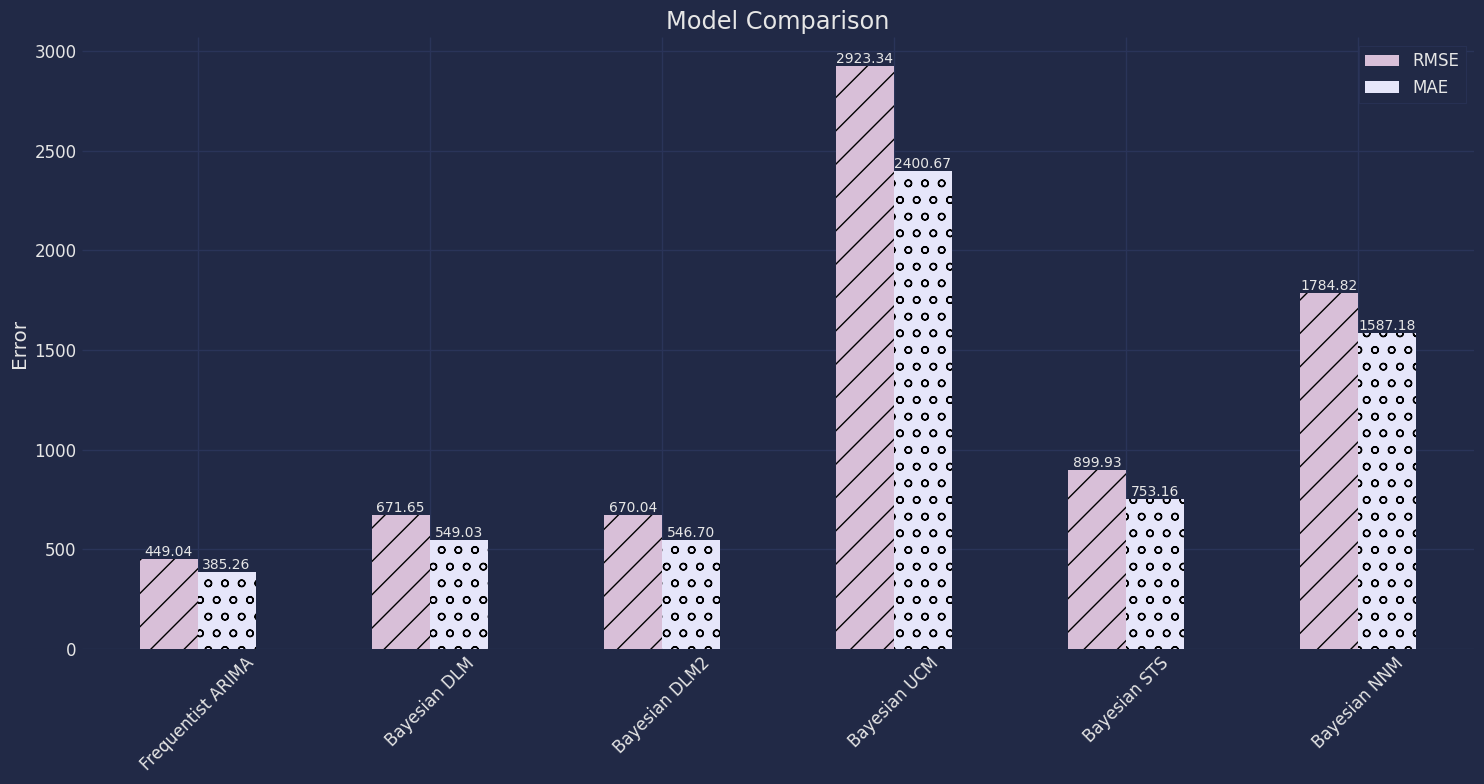

In [55]:
# Plot model comparison
colors = ['thistle', 'lavender']
hatches = ['/', 'o']
ax = df_metrics[["RMSE", "MAE"]].plot(kind='bar', figsize=(15, 8), color=colors)
plt.title('Model Comparison')
plt.ylabel('Error')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
leg = ax.legend()
for line in leg.get_lines():
    line.set_linewidth(1.5)
plt.xticks(rotation=45)
for container, hatch in zip(ax.containers, hatches):
    for bar in container:
        bar.set_hatch(hatch)
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{height:.2f}',
                ha='center',
                va='bottom',
                fontsize=10
            )
plt.tight_layout()
plt.show()

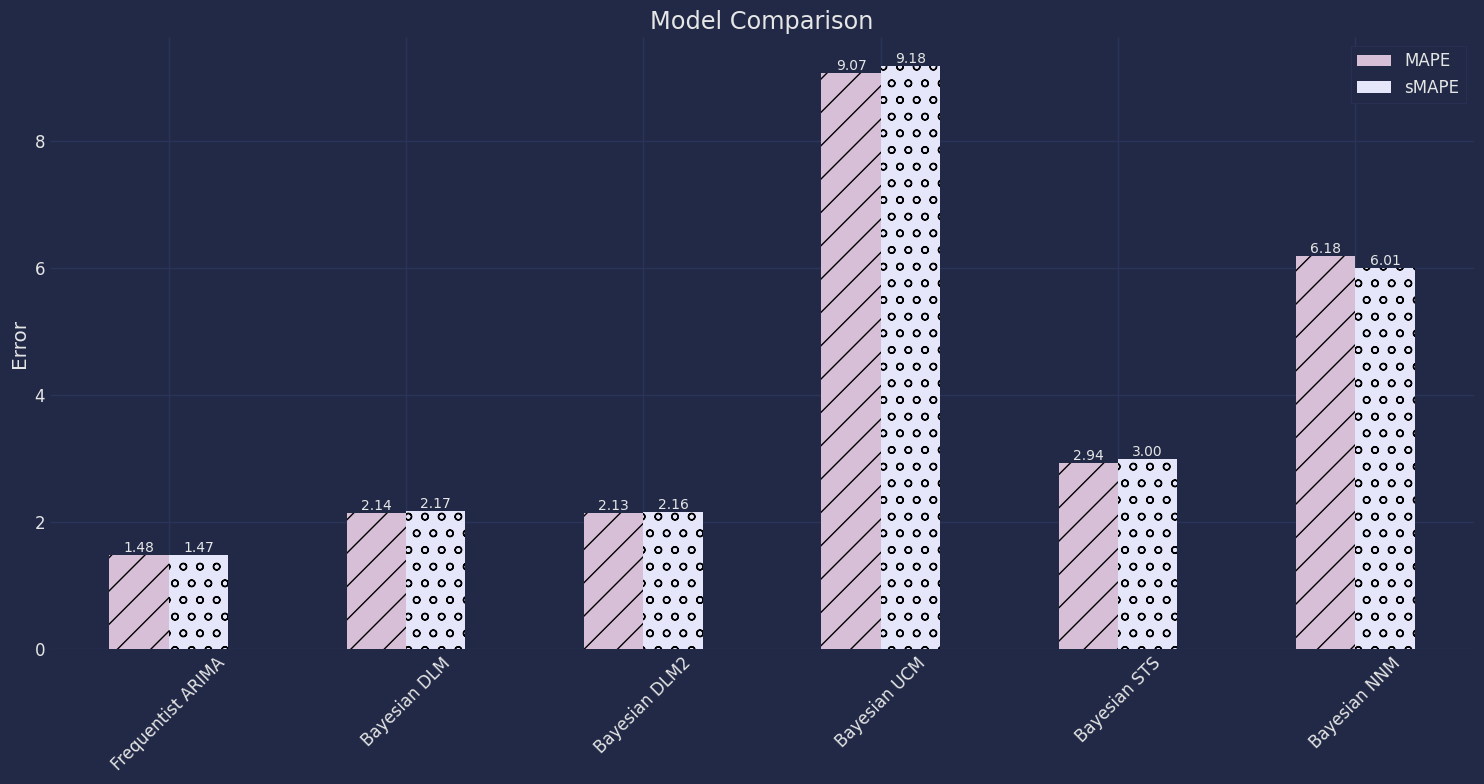

In [56]:
# Plot model comparison
colors = ['thistle', 'lavender']
hatches = ['/', 'o']
ax = df_metrics[["MAPE", "sMAPE"]].plot(kind='bar', figsize=(15, 8), color=colors)
plt.title('Model Comparison')
plt.ylabel('Error')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
leg = ax.legend()
for line in leg.get_lines():
    line.set_linewidth(1.5)
plt.xticks(rotation=45)
for container, hatch in zip(ax.containers, hatches):
    for bar in container:
        bar.set_hatch(hatch)
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{height:.2f}',
                ha='center',
                va='bottom',
                fontsize=10
            )
plt.tight_layout()
plt.show()

# Forecast Plotting

In [57]:
def plot_forecasts_comparison(df: pd.DataFrame, forecast_index: pd.DatetimeIndex, forecasts: Dict[str, np.ndarray]) -> None:
    """
    Plot the test set actual values along with forecasts from multiple models.

    The test set actual values are plotted as a black dashed line, and forecast
    lines from each model are plotted in distinct colors.

    Parameters:
        df: pd.DataFrame containing the full dataset with a datetime index and a 'values' column.
        forecast_index: pd.DatetimeIndex corresponding to the forecast horizon (test set).
        forecasts: Dictionary mapping model names to their forecasted values (np.ndarray).
    """
    fig, ax = plt.subplots(figsize=(15, 8))

    # Plot the actual test set values as a black dashed line
    test_values = df.loc[forecast_index, 'values']
    ax.plot(
        forecast_index,
        test_values,
        label='Actual (Test Set)',
        color='black',
        linestyle='--',
        linewidth=2
    )

    # Define colors and markers
    colors = ['lightcoral', 'navajowhite', 'lemonchiffon', 'springgreen', 'cornflowerblue', 'darkorchid']
    markers = ['o', 's', '^', '*', 'p', 'X']

    # Plot each model's forecast with a unique color/marker combo
    for i, (model_name, forecast) in enumerate(forecasts.items()):
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        ax.plot(
            forecast_index,
            forecast,
            label=model_name,
            color=color,
            marker=marker,
            linewidth=2
        )

    ax.set_title("Forecast Comparison: Actual vs. Model Forecasts")
    ax.set_xlabel("Time")
    ax.set_ylabel("Demand")
    leg = ax.legend()
    for line in leg.get_lines():
        line.set_linewidth(1.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

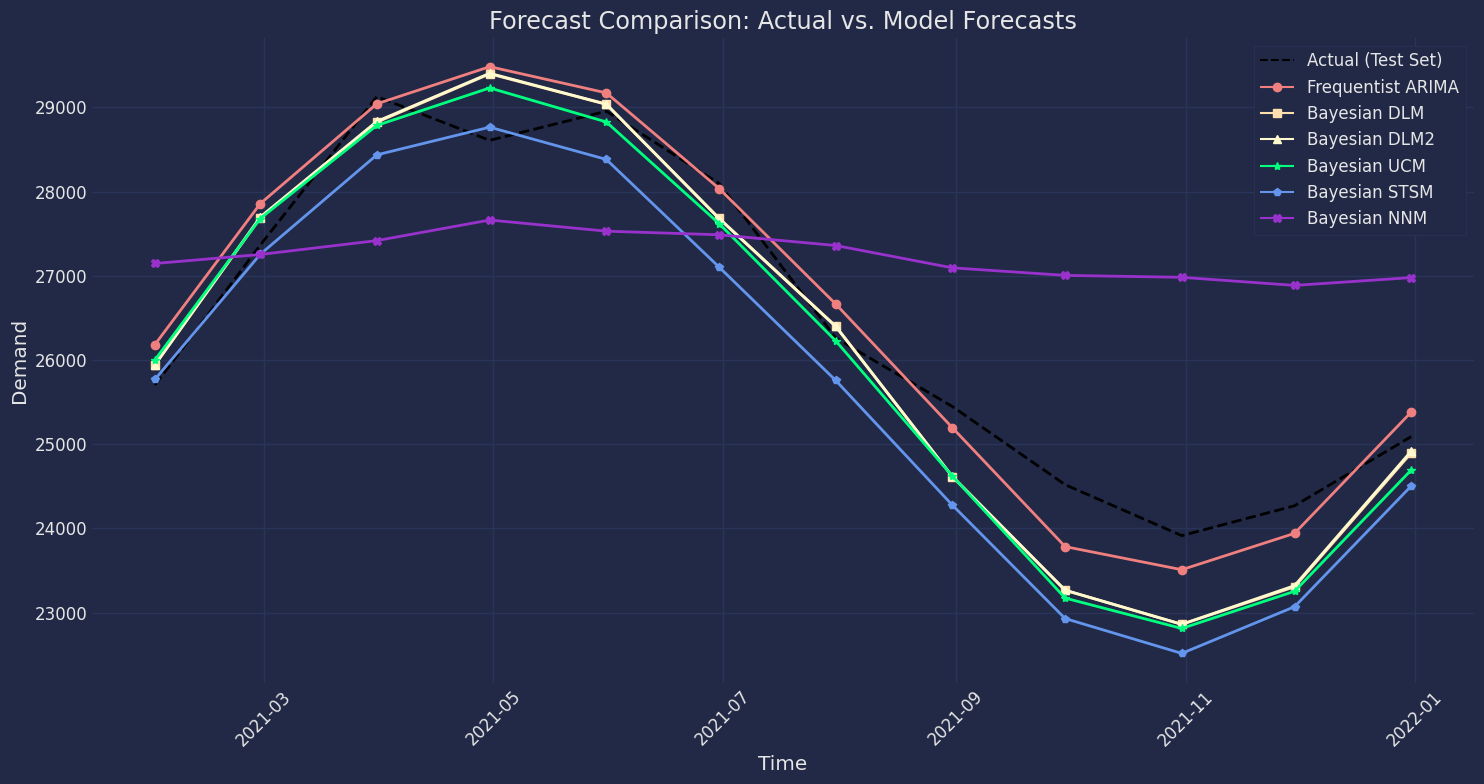

In [58]:
# Create the forecast index from the full DataFrame (last forecast_horizon timestamps)
forecast_index = df.index[-forecast_horizon:]

# Create a dictionary mapping model names to their forecasts
forecasts = {
    "Frequentist ARIMA": arima_forecast,
    "Bayesian DLM": bdlm_forecast,
    "Bayesian DLM2": bdlm2_forecast,
    "Bayesian UCM": bucm_forecast,
    "Bayesian STSM": bstsm_forecast,
    "Bayesian NNM": bnnm_forecast
}

# Compare forecasts with actual test values
plot_forecasts_comparison(df, forecast_index, forecasts)